In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression

from scipy import stats

Using TensorFlow backend.


# Custom Methods

In [2]:
def get_missing_value_count(data,feature):
    return (data[data[feature].isna() == True].shape[0]/data[feature].shape[0])*100

In [3]:
def encode_categorical_variable(data, feature):
    oe = OrdinalEncoder()
    data[feature] = oe.fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))
    return data[feature]

In [4]:
def impute_by_constant(data, feature, const_value):
    return data[feature].fillna(const_value)

In [5]:
def impute_by_mice(data, feature, data_type):
    if data_type == 'float':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(float)).reshape(-1, 1))
    elif data_type == 'str':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))

In [6]:
def impute_by_knn(data, neighbors):
    features = data.columns
    temp_df = KNNImputer(n_neighbors=neighbors).fit_transform(data) #imputation returns nd-array
    return pd.DataFrame(temp_df, columns=features) #convert nd-array to series

In [7]:
def scale_variable(dataset, target_var):
    #separate the target variable
    dataset = loan_data.copy()
    target = dataset[target_var]
    dataset.drop([target_var], axis=1, inplace=True)
    #scaling of features
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset = pd.DataFrame(scaler.transform(dataset), columns=dataset.columns)
    #add target back to dataset
    dataset[target_var] = target.reset_index().drop(['index'], axis=1)[target_var]
    return dataset

In [8]:
def variable_scale_analysis(dataset, features, graph_name):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_title(graph_name)
    for feature in features:
        print(feature, ' : ', dataset[feature].dtype)
        sns.kdeplot(dataset[feature], ax=ax1, cumulative=True, bw=1.5)
    plt.show()

In [9]:
# Binning of dependent variable into categories: Good, Bad and Current loan
def loan_type(status):
    bad_loan = ['Charged Off', 'Default', 'Late (31-120 days)']
    current_loan = ['Current', 'In Grace Period', 'Late (16-30 days)']
    if status in bad_loan:
        return 0
        #return 'Bad Loan'
    elif status in current_loan:
        return 2
        #return 'Current Loan'
    else:
        return 1
        #return 'Good Loan'

In [10]:
def get_heat_map(data, features, x_size, y_size, title):
    f, ax = plt.subplots(figsize=(x_size, y_size))
    corr = data[features].corr()
    print(corr)
    '''
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
                     cmap=sns.diverging_palette(240,10,as_cmap=True), 
                     annot=True, vmin=-1, vmax=1)
    ax.set_title(title)
    '''

# Read dataset

In [11]:
loan_data = pd.read_csv('datasets/LendingClub/AcceptedLoans_2007_to_2018.csv', low_memory=False)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing the data

In [12]:
indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Total amount funded in policy code')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Loans that do not meet the credit policy')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

In [13]:
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Fully Paid', 
                                                  value='Fully Paid')
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Charged Off', 
                                                  value='Charged Off')

In [14]:
indexes = loan_data[loan_data['loan_status'].isin(['Issued', 'Current', 'In Grace Period', 'Late (16-30 days)'])].index
loan_data.drop(indexes , inplace=True)

In [15]:
loan_data['loan_type'] = loan_data['loan_status'].apply(loan_type)

In [16]:
loan_data['issue_d'] = (pd.to_datetime(loan_data['issue_d']).dt.year).astype(int)

In [17]:
loan_data['emp_length'].fillna(value=0,inplace=True)
loan_data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data['emp_length'] = loan_data['emp_length'].astype(int)
loan_data['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)

In [18]:
loan_data = loan_data.sample(n=round(0.05*loan_data.shape[0]))
print('The sampled dataset has ',loan_data.shape[0],' records and ',loan_data.shape[1],' variables.')

The sampled dataset has  68478  records and  152  variables.


In [19]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  68478  records and  152  variables.


# Feature Engineering

**Dropping features having redundant data, too many missing values and high correlation with other features**

In [20]:
cols_to_be_dropped = ['loan_status','acc_now_delinq','all_util','application_type','desc','earliest_cr_line',
                      'emp_title','fico_range_low','funded_amnt_inv','grade','id','il_util','inq_fi',
                      'installment','last_credit_pull_d','last_fico_range_high','last_fico_range_low','last_pymnt_d',
                      'loan_amnt','max_bal_bc','member_id','num_tl_120dpd_2m','num_tl_op_past_12m','open_acc_6m',
                      'open_il_24m','open_rv_24m','out_prncp','out_prncp_inv','pymnt_plan','tot_cur_bal',
                      'total_bal_il','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp',
                      'url','zip_code','sec_app_earliest_cr_line', 'hardship_type','deferral_term','hardship_length',
                      'disbursement_method','last_pymnt_amnt', 'mths_since_last_major_derog', 'mths_since_last_record',
                      'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 
                      'open_il_12m', 'open_act_il', 'open_rv_12m', 'total_cu_tl', 'revol_bal_joint', 'policy_code',
                      'recoveries', 'collection_recovery_fee']

In [21]:
loan_data.drop(cols_to_be_dropped, axis=1, inplace=True)

In [22]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  68478  records and  94  variables.


In [23]:
## This is a temporay step where features that are pending EDA have been dropped.
## Step will be removed once EDA phase is complete

temp_cols_imputed = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',
                     'mths_since_last_delinq', 'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd',
                     'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl', 'num_op_rev_tl',
                     'num_rev_accts','num_rev_tl_bal_gt_0','num_sats','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec',
                     'pub_rec_bankruptcies','revol_bal','revol_util','tax_liens','tot_coll_amt']

for feature in temp_cols_imputed:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].median())

In [24]:
## This is a temporay step where features that are pending EDA have been dropped.
## Step will be removed once EDA phase is complete
temp_cols_dropped = ['sec_app_fico_range_low','sec_app_fico_range_high', 'sec_app_inq_last_6mths',
                     'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts',
                     'sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog', 
                     'hardship_flag','hardship_reason','hardship_status','hardship_amount','hardship_start_date',
                     'hardship_end_date','payment_plan_start_date','hardship_dpd','hardship_loan_status',
                     'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount',
                     'debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date',
                     'settlement_amount','settlement_percentage','settlement_term','title']

loan_data.drop(temp_cols_dropped, axis=1, inplace=True)

print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  68478  records and  63  variables.


**Handling Missing Values (using zero imputation)**

In [25]:
cols_for_zero_imputation = ['acc_open_past_24mths','annual_inc_joint','chargeoff_within_12_mths',
                            'collections_12_mths_ex_med','delinq_2yrs','dti_joint','num_tl_30dpd','num_tl_90g_dpd_24m',
                            'open_acc','total_bc_limit','total_il_high_credit_limit', 'delinq_amnt', 'total_acc']

In [26]:
for feature in cols_for_zero_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, 0)

**Handling Missing Values (using median imputation)**

In [27]:
cols_for_median_imputation = ['annual_inc','dti','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim', 'bc_open_to_buy',
                              'bc_util', 'total_bal_ex_mort']

In [28]:
for feature in cols_for_median_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].median())

**Handling Missing Values (using mode imputation)**

In [29]:
cols_for_mode_imputation = []

**Encoding categorical features**

In [30]:
cols_for_encoding = ['term','sub_grade','home_ownership','verification_status','purpose','addr_state',
                     'initial_list_status']

In [31]:
for feature in loan_data.columns:
    if loan_data[feature].dtype == 'object':
        loan_data[feature] = encode_categorical_variable(loan_data, feature)

**Handling Missing Values (using knn imputation)**

In [32]:
cols_for_knn_imputation = ['emp_length', 'inq_last_12m', 'inq_last_6mths']

In [33]:
#X = impute_by_knn(X, 4)

In [34]:
## knn imputation throwing error. hence applied mode imputation
for feature in cols_for_knn_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].mode().get(0))

**Handling Missing Values (using 'missing' indicator imputation in categorical variables)**

In [35]:
loan_data['verification_status_joint'] = impute_by_constant(loan_data, 'verification_status_joint', 'Not Applicable')

**Feature Scaling**

In [36]:
loan_data = scale_variable(loan_data, 'loan_type')

# Modelling Preparation

**Dropping columns as per feature selection results from previous tests**

In [37]:
'''
cols_dropped_post_feature_selection = []
loan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)
'''

'\ncols_dropped_post_feature_selection = []\nloan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)\n'

**Get the feature and target variables**

In [38]:
y = loan_data['loan_type']
X = loan_data.drop(['loan_type'], axis=1)

loan_data.drop(['loan_type'], axis=1, inplace=True)

print('Now, the dataset has ', X.shape[0], ' records and ', X.shape[1], ' variables.')

Now, the dataset has  68478  records and  62  variables.


**Define k for cross-validation**

In [39]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
skf = StratifiedKFold(n_splits=3)
n_split = skf.get_n_splits(X)
print('Number of folds: ', n_split)

Number of folds:  3


**Hyper parameter tuning**

In [40]:
'''
clf = LogisticRegression(random_state=0)
parameters = {
    'solver': ['sag'],
    'C':  [1, 10, 100],
    'penalty':  ['l2'],
    'multi_class': ['ovr'],
    'max_iter' : [1000]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='precision_weighted', cv=n_split, verbose=20)
grid.fit(X_scaled, y)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

'''
# 0.9125633304946389
'solver': ['sag'],
'C':  [1],
'penalty':  ['l2'],
'multi_class': ['ovr']
'''

"\n# 0.9125633304946389\n'solver': ['sag'],\n'C':  [1],\n'penalty':  ['l2'],\n'multi_class': ['ovr']\n"

**Modelling: Train, Test and Model Assessment**

In [41]:
for train_index, test_index in skf.split(X, y):
    print('*******************Start of split*******************')
    ## split into train and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## model fitting using train data
    lg_clf = LogisticRegression(solver='sag', C=1 , penalty='l2', multi_class='auto', 
                            max_iter=10000, n_jobs=-1, random_state=0)
    lg_clf.fit(X_train, y_train)
    ## predicting using test data
    y_pred = lg_clf.predict(X_test)
    ## assessing model performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)
    print('Accuracy : ', acc)
    print('Precision : ', prec)
    print('Recall : ', rec)
    print('F1 : ', f1)
    #print('ROC-AUC Score: ', roc_auc)

*******************Start of split*******************
Accuracy :  0.791772540085867
Precision :  0.8026110856619331
Recall :  0.9752852769273588
F1 :  0.8805628847845206
*******************Start of split*******************
Accuracy :  0.7901077718391308
Precision :  0.8018236803519062
Recall :  0.9740606735318675
F1 :  0.8795898363869411
*******************Start of split*******************
Accuracy :  0.7915534916323491
Precision :  0.8029545350277562
Recall :  0.9742276649039799
F1 :  0.8803380111664403


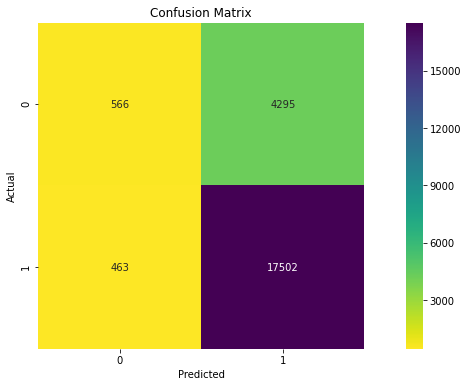

In [42]:
## confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.savefig('pics/confusion_matrix.png')

~30% of bad loans are predicted as good loans.

~4.15% of good loans are predicted as bad loans.

AUC Score:  0.7134495501521766


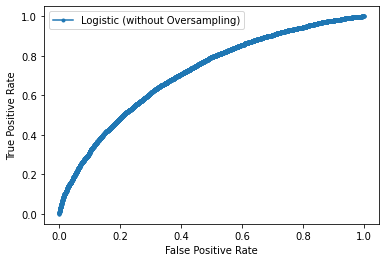

<Figure size 432x288 with 0 Axes>

In [50]:
y_proba = lg_clf.predict_proba(X_test)[:, 1]
print('AUC Score: ', roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, marker='.', label='Logistic (without Oversampling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.savefig('pics/auc_curve.png')

**Find the best features of the dataset**

In [44]:
importance = pd.Series(lg_clf.coef_[0], index=list(X_train.columns))

feature_imp_df = pd.DataFrame({'Feature_Name': list(X_train.columns),
                               'Feature_Importance': importance})
feature_imp_df.sort_values(by=['Feature_Importance'], ascending=True, inplace=True)

                                          Feature_Name  Feature_Importance
mo_sin_old_il_acct                  mo_sin_old_il_acct            0.000770
num_tl_30dpd                              num_tl_30dpd            0.002172
mo_sin_old_rev_tl_op              mo_sin_old_rev_tl_op            0.003521
tot_hi_cred_lim                        tot_hi_cred_lim            0.005217
num_actv_bc_tl                          num_actv_bc_tl            0.015159
annual_inc                                  annual_inc            0.015781
mo_sin_rcnt_rev_tl_op            mo_sin_rcnt_rev_tl_op            0.016759
addr_state                                  addr_state            0.018965
initial_list_status                initial_list_status            0.021211
mths_since_recent_bc              mths_since_recent_bc            0.021967
num_accts_ever_120_pd            num_accts_ever_120_pd            0.025523
mo_sin_rcnt_tl                          mo_sin_rcnt_tl            0.026355
total_rev_hi_lim         

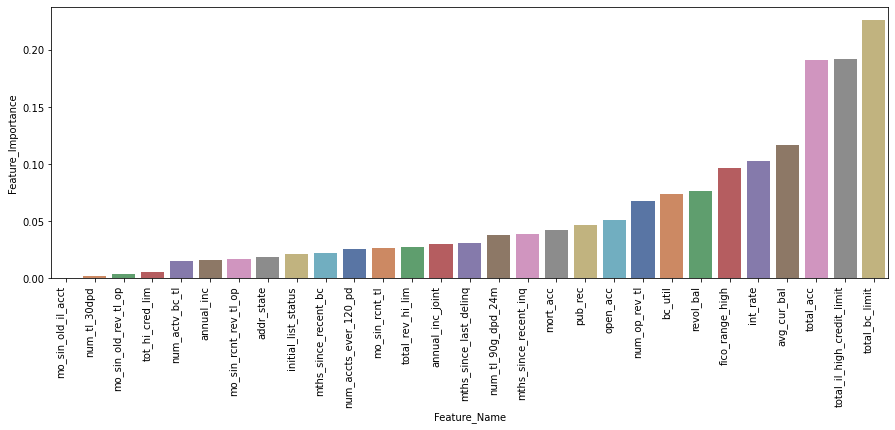

In [48]:
feature_imp_df_positive = feature_imp_df[feature_imp_df['Feature_Importance'] >= 0]
print(feature_imp_df_positive)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='Feature_Name', y='Feature_Importance', data=feature_imp_df_positive, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig('pics/logistic_reg_oversampling_feature_importance_poistive.png')

                                          Feature_Name  Feature_Importance
sub_grade                                    sub_grade           -0.449218
issue_d                                        issue_d           -0.288408
term                                              term           -0.244750
total_bal_ex_mort                    total_bal_ex_mort           -0.207871
funded_amnt                                funded_amnt           -0.158853
dti                                                dti           -0.148804
home_ownership                          home_ownership           -0.124046
acc_open_past_24mths              acc_open_past_24mths           -0.109421
num_bc_sats                                num_bc_sats           -0.077199
revol_util                                  revol_util           -0.076789
percent_bc_gt_75                      percent_bc_gt_75           -0.076639
bc_open_to_buy                          bc_open_to_buy           -0.075223
num_rev_tl_bal_gt_0      

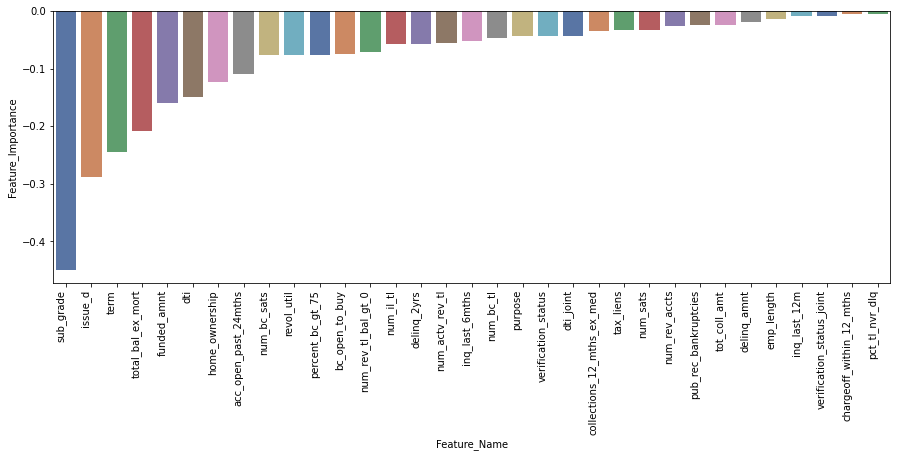

In [49]:
feature_imp_df_negative = feature_imp_df[feature_imp_df['Feature_Importance'] < 0]
print(feature_imp_df_negative)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='Feature_Name', y='Feature_Importance', data=feature_imp_df_negative, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig('pics/logistic_reg_oversampling_feature_importance_negative.png')

In [47]:
coefficients_df = pd.concat([pd.DataFrame(X_train.columns), 
                          pd.DataFrame(np.transpose(lg_clf.coef_))], 
                          axis = 1)
coefficients_df.head(10)

,0,0
0,funded_amnt,-0.158853
1,term,-0.244750
2,int_rate,0.103042
3,sub_grade,-0.449218
4,emp_length,-0.013823
5,home_ownership,-0.124046
6,annual_inc,0.015781
7,verification_status,-0.043605
8,issue_d,-0.288408
9,purpose,-0.044117
